In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA


In [59]:
import statsmodels.api as sm

In [12]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df = pd.read_csv('/Users/Daniyar/Mountains/Data/df_clean.csv', index_col="time")



In [9]:
X = df.drop(columns='price actual')
y = df['price actual']

In [37]:
print(df.index.tz)

UTC


In [4]:
print(df.columns.tolist())

['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual', 'temp_Barcelona', 'pressure_Barcelona', 'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona', 'rain_1h_Barcelona', 'clouds_all_Barcelona', 'weather_broken clouds_Barcelona', 'weather_few clouds_Barcelona', 'weather_light rain_Barcelona', 'weather_others_Barcelona', 'weather_scattered clouds_Barcelona', 'weather_sky is clear_Barcelona', 'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao', '

In [5]:
def prep_split(df, columns_drop, label, train_end_date, hours_ahead):
    # Add a column with the label shifted by "hours" rows

    if hours_ahead == 0:
        df['label_shifted'] = df[label]
    else:
        df['label_shifted'] = df[label].shift(-hours_ahead)
        # Drop the last "hours" rows as they have no label values
        df = df.iloc[:-hours_ahead]
   
    
    def split_by_date(X, train_end_date):
        if not isinstance(train_end_date, pd.Timestamp):
            train_end_date = pd.Timestamp(train_end_date)

        # Convert index of X and y to Timestamp objects if they are strings
        if isinstance(X.index[0], str):
            X.index = pd.to_datetime(X.index)

        X_train = X[X.index <= train_end_date]
        X_test = X[X.index > train_end_date]

        return X_train, X_test

    X = df.drop(columns=columns_drop + ['label_shifted'])
    y = df['label_shifted']

    X_train, X_test = split_by_date(X, train_end_date)
    y_train, y_test = split_by_date(y, train_end_date)

    # Standardize all columns except target
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = prep_split(df, 
                                               columns_drop=[], 
                                               label='price actual', 
                                               train_end_date='2017-12-31 23:00:00+00:00',
                                               hours_ahead=3)

In [10]:
df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0,weekday_dummy,label_shifted
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,0,0,0,0,0,0,0,1,1,59.32
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,0,0,0,0,0,0,0,0,1,56.04
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,0,0,0,0,0,0,0,0,1,53.63
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,0,0,0,0,0,0,0,0,1,51.73
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,0,0,0,0,0,0,0,0,1,51.43


In [11]:
df.index = pd.to_datetime(df.index)

In [13]:
# Check for stationarity
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.147016
p-value: 0.000000


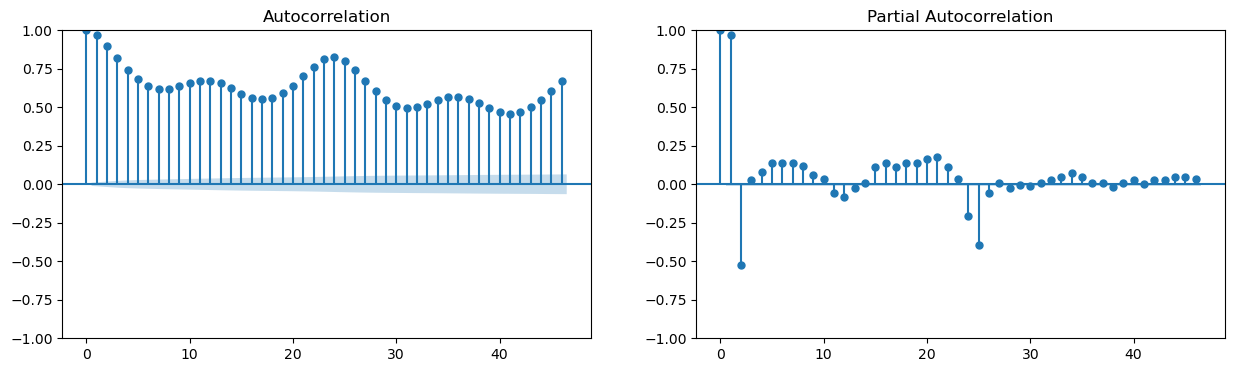

In [14]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(y.dropna(), ax=axes[0])
plot_pacf(y.dropna(), ax=axes[1])
plt.show()

In [28]:
model_arima = ARIMA(y_train, order=(1,0,0))
model_arima_fit = model_arima.fit()
model_arima_fit.summary()

/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          label_shifted   No. Observations:                26305
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -71942.873
Date:                Fri, 03 May 2024   AIC                         143891.746
Time:                        16:16:09   BIC                         143916.278
Sample:                    12-31-2014   HQIC                        143899.667
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.0273      0.694     80.702      0.000      54.667      57.388
ar.L1          0.9657      0.002    629.693      0.000       0.963       0.969
sigma2        13.9000      0.076    183.488      0.000      13.752      14.049
===================================================================================
Ljung-Box (L1) (Q):                6729.31   Jarque-Bera (JB):             14930.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

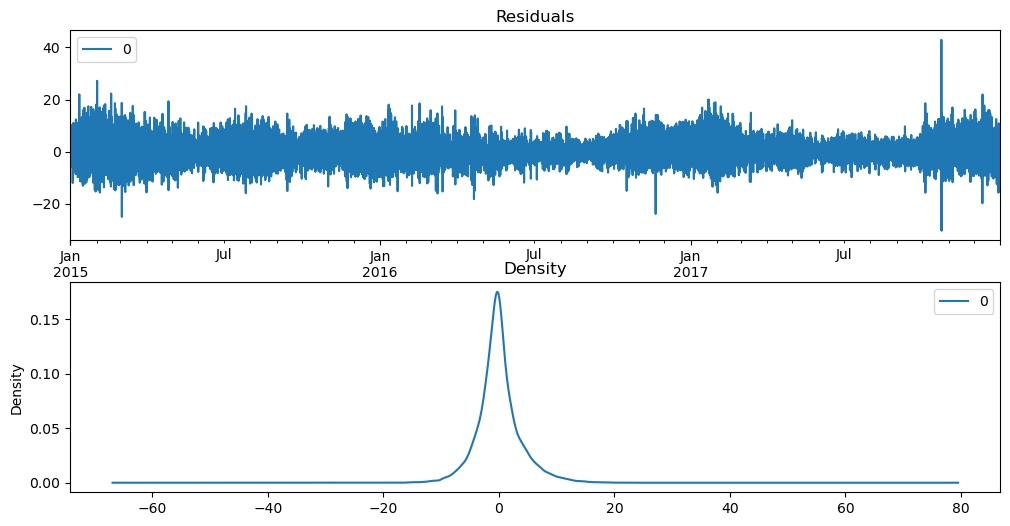

In [29]:
residuals = pd.DataFrame(model_arima_fit.resid)

plt.figure(figsize=(12,6))
plt.subplot(211)
residuals.plot(title="Residuals", ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', title='Density', ax=plt.gca())
plt.show()

In [42]:
# Forecast
n_forecasts = len(y_test)  # Replace with the actual length of your test set
forecast_result = model_arima_fit.get_forecast(n_forecasts)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()



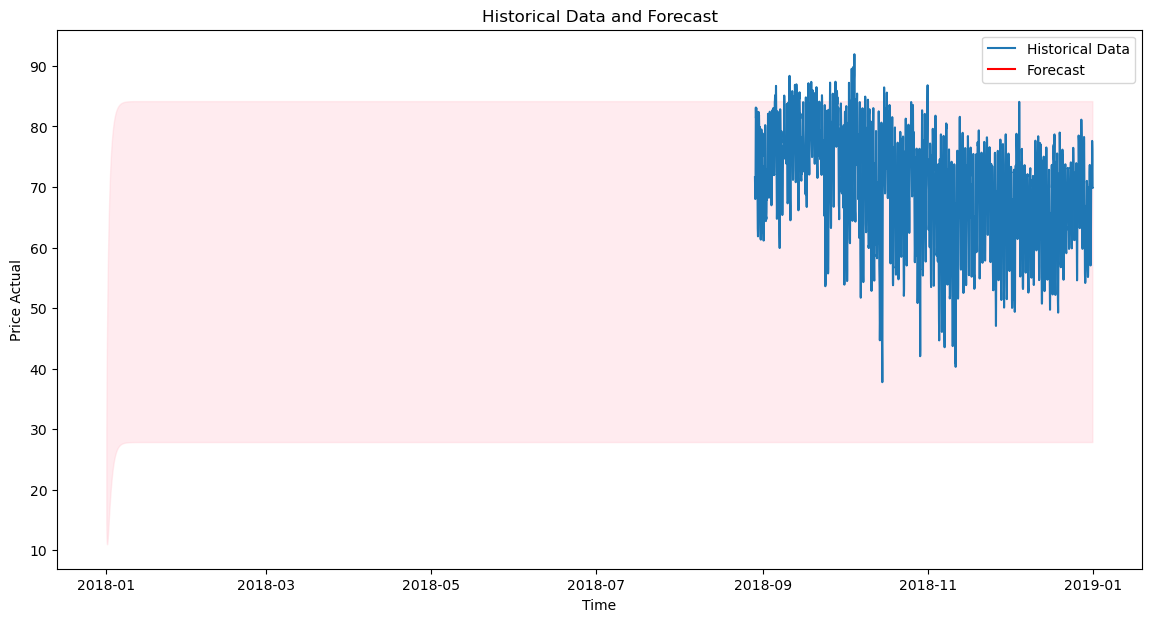

In [44]:
tz_info = df.index.tz  # Get timezone from the DataFrame index
last_index = df.index[-1]
forecast_index = pd.date_range(start=last_index, periods=4, freq='H', tz=tz_info)[1:]

forecast_series = pd.Series(forecast_mean, index=forecast_index)
historical = df['price actual'].tail(3000)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(historical.index, historical, label='Historical Data')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Historical Data and Forecast')
plt.xlabel('Time')
plt.ylabel('Price Actual')
plt.legend()
plt.show()

In [38]:
tz_info = df.index.tz  # Get timezone from the DataFrame index
last_index = df.index[-1]
forecast_index = pd.date_range(start=last_index, periods=4, freq='H', tz=tz_info)[1:]

In [39]:

# Extract the last 50 observations to plot alongside the forecast
historical = y.tail(50)

# Combine historical data with forecast for a continuous plot
forecast_index = pd.date_range(start=historical.index[-1], periods=4, freq='H')[1:]  # Adjust frequency as needed
forecast_series = pd.Series(forecast, index=forecast_index)
combined = pd.concat([historical, forecast_series])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(historical.index, historical, label='Historical Data')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Historical Data and Forecast')
plt.xlabel('Time')
plt.ylabel('Price Actual')
plt.legend()
plt.show()

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'UnitData'

<Figure size 1400x700 with 1 Axes>

In [31]:
print(forecast_results)

2018-01-01 00:00:00+00:00    22.084443
2018-01-01 01:00:00+00:00    23.247611
2018-01-01 02:00:00+00:00    24.370920
2018-01-01 03:00:00+00:00    25.455735
2018-01-01 04:00:00+00:00    26.503375
                               ...    
2018-12-31 15:00:00+00:00    56.027339
2018-12-31 16:00:00+00:00    56.027339
2018-12-31 17:00:00+00:00    56.027339
2018-12-31 18:00:00+00:00    56.027339
2018-12-31 19:00:00+00:00    56.027339
Freq: H, Name: predicted_mean, Length: 8756, dtype: float64


ValueError: operands could not be broadcast together with shapes (8756,) (3,) 

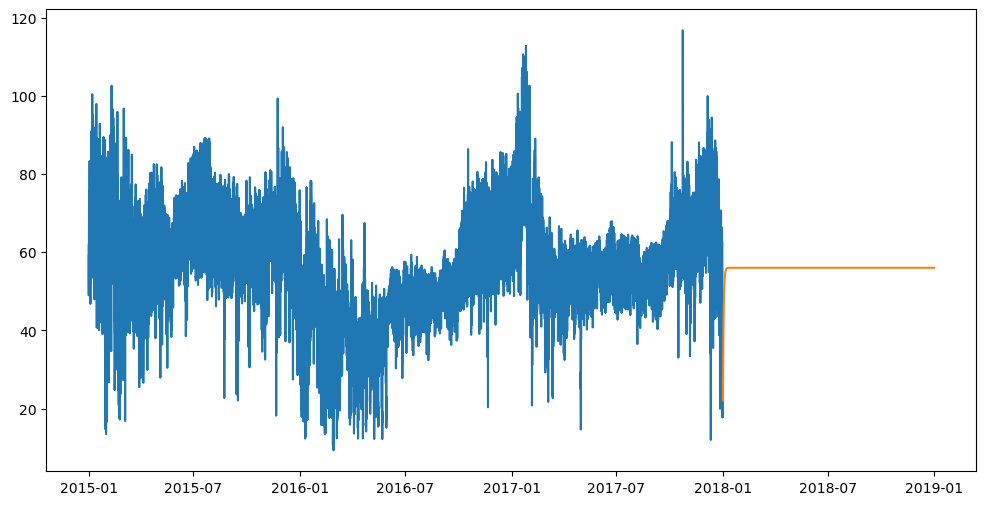

In [32]:
# Plot the forecast alongside the historical data
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Historical')
plt.plot(y_test.index, forecast_results, label='Forecast')
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Solar Generation Forecast')
plt.legend()
plt.show()

In [46]:
arima_pred = model_arima_fit.predict(start = len(X_train), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2018-01-01 00:00:00+00:00    22.084443
2018-01-01 01:00:00+00:00    23.247611
2018-01-01 02:00:00+00:00    24.370920
2018-01-01 03:00:00+00:00    25.455735
2018-01-01 04:00:00+00:00    26.503375
                               ...    
2018-12-31 18:00:00+00:00    56.027339
2018-12-31 19:00:00+00:00    56.027339
2018-12-31 20:00:00+00:00    56.027339
2018-12-31 21:00:00+00:00    56.027339
2018-12-31 22:00:00+00:00    56.027339
Freq: H, Name: ARIMA Predictions, Length: 8759, dtype: float64

56.027339    7703
56.027339      32
56.027339      14
56.027339      10
56.027339       7
             ... 
56.026973       1
56.026986       1
56.026998       1
56.027009       1
56.027338       1
Name: ARIMA Predictions, Length: 969, dtype: int64

In [47]:
X_test

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0,weekday_dummy
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,-1.381706,-1.312608,-1.007472,-1.717242,-2.086531,1.996181,0.426279,-0.914278,0.886671,-0.535955,...,-0.299098,-0.304496,-0.299098,-0.304496,-0.304496,-0.299098,-0.304496,-0.299098,-0.304571,0.408891
2018-01-01 01:00:00+00:00,-1.348303,-1.312608,-0.887730,-1.690149,-2.086531,1.899418,0.431696,-0.861291,0.887882,-0.535955,...,-0.299098,-0.304496,-0.299098,-0.304496,-0.304496,-0.299098,-0.304496,-0.299098,-0.304571,0.408891
2018-01-01 02:00:00+00:00,-1.348303,-1.312608,-0.927790,-1.675863,-2.086531,2.009827,0.358570,-0.959772,0.891514,-0.489310,...,-0.299098,-0.304496,-0.299098,-0.304496,-0.304496,-0.299098,-0.304496,-0.299098,-0.304571,0.408891
2018-01-01 03:00:00+00:00,-1.337169,-1.312608,-0.985901,-1.666010,-2.086531,2.573036,0.391070,-0.988138,0.897567,-0.535955,...,-0.299098,-0.304496,-0.299098,-0.304496,-0.304496,-0.299098,-0.304496,-0.299098,-0.304571,0.408891
2018-01-01 04:00:00+00:00,-1.348303,-1.312608,-0.978857,-1.670444,-2.086531,2.528376,0.336903,-1.014364,0.901199,-0.535955,...,-0.299098,-0.304496,-0.299098,-0.304496,-0.304496,-0.299098,-0.304496,-0.299098,-0.304571,0.408891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 15:00:00+00:00,-1.103355,-1.312608,0.361643,-0.956647,-2.327111,-0.226880,0.431696,-0.262376,-0.305809,-0.069501,...,-0.299098,-0.304496,-0.299098,-0.304496,-0.304496,-0.299098,-0.304496,-0.299098,3.283309,0.408891
2018-12-31 16:00:00+00:00,-1.125623,-1.312608,0.587481,-0.917238,-2.345618,-0.473749,0.540030,0.083913,-0.305809,-0.069501,...,-0.299098,-0.304496,-0.299098,-0.304496,-0.304496,-0.299098,-0.304496,-0.299098,3.283309,0.408891
2018-12-31 17:00:00+00:00,-1.181293,-1.312608,0.896083,-0.906893,-2.327111,-0.626336,0.656489,0.801647,-0.305809,-0.069501,...,-0.299098,-0.304496,-0.299098,-0.304496,-0.304496,-0.299098,-0.304496,-0.299098,3.283309,0.408891


<AxesSubplot:xlabel='time'>

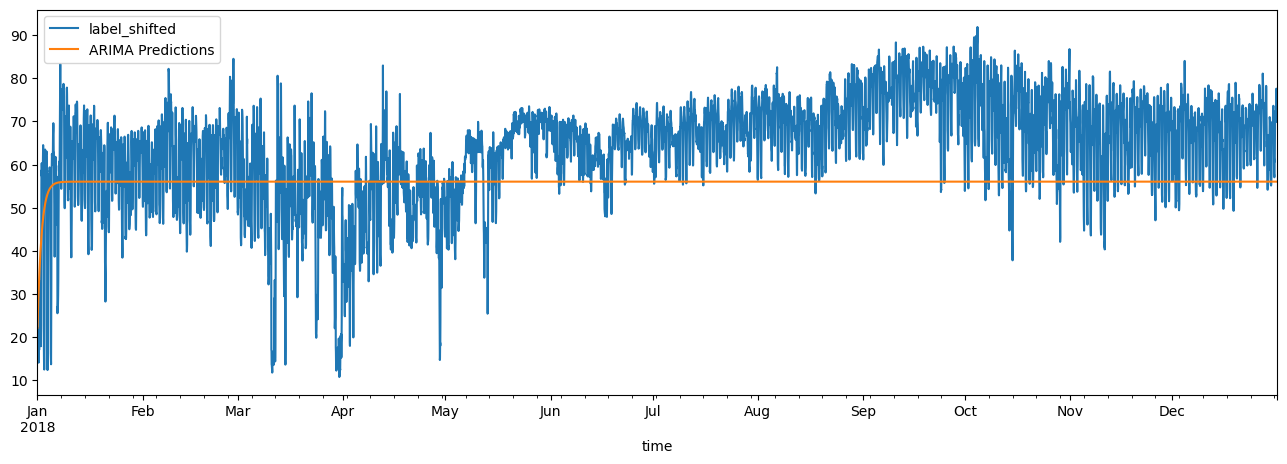

In [55]:
y_test.plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True)

<AxesSubplot:>

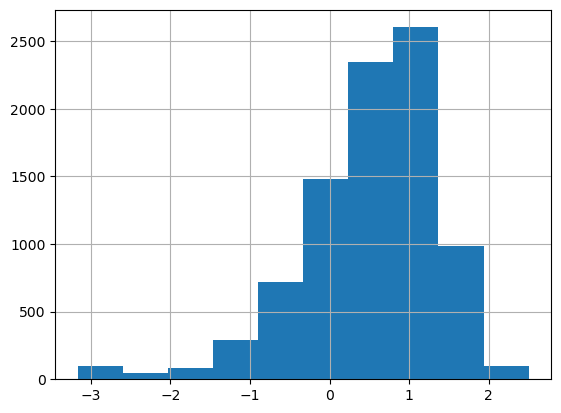

In [52]:
X_test['price actual'].hist()

<AxesSubplot:>

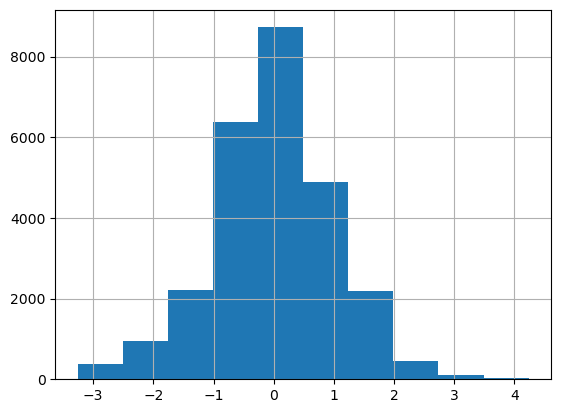

In [53]:
X_train['price actual'].hist()